In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from google.cloud import bigquery
import os

from datetime import timedelta
import warnings

os.chdir('/home/jupyter')
!pwd
# # %cd 
# !pwd

# Define project on BQ
project_id = "starfire-410116"

# Authenticate to Google Cloud
client = bigquery.Client(project=project_id)

# Set allow_large_results to True
job_config = bigquery.QueryJobConfig()
job_config.allow_large_results = True


from IPython.display import HTML

import refinitiv.dataplatform as rdp

%run ./starfire/notebooks/credentials.ipynb

session = rdp.open_platform_session(
    APP_KEY,
    rdp.GrantPassword(
        username = RDP_LOGIN,
        password = RDP_PASSWORD
    )
)


/home/jupyter


## Get RIC stock market prices around announcement date

In [63]:
#download deals data
# Download data from BQ
print('downloading deals... \n')

# Construct the SQL query to fetch data from BigQuery
query = f'''
SELECT 
    mnasdcdealnumber, 
    mnaanndate, 
    --mnaacquirorpritickersym, mnaacquirorultparentpritickersym, 
    CASE WHEN mnaacquirorpritickersym = "" THEN mnaacquirorultparentpritickersym ELSE mnaacquirorpritickersym END as ticker
FROM `starfire-410116.derived.refinitiv_deals_3` 
WHERE mnaacquirorpritickersym != '' OR mnaacquirorultparentpritickersym != ''
ORDER BY mnaacquirorultparentpritickersym ASC
'''

# Fetch data from BigQuery
query_job = client.query(query, job_config=job_config)
results = query_job.result()  # Waits for the query to complete

# Convert the result to a pandas DataFrame
df_deals = results.to_dataframe()

# Print the first few rows of the DataFrame
print('All deals:')
print(f'shape: {df_deals.shape}')
df_deals.head(4)


downloading pitchbook startups_all... 

All deals:
shape: (709122, 3)


,mnasdcdealnumber,mnaanndate,ticker
0,962926040,2000-01-07,BSCJF
1,959477040,2000-01-07,EMC
2,959752040,2000-01-07,MAGO
3,959872040,2000-01-10,267


In [69]:
# Create list of acquiror tickers from deals df to pass into next query
ticker_list = df_deals['ticker'].tolist()
len(ticker_list)


709122

In [71]:
# Define chunk size
chunk_size = 1000
print(f'length: {len(ticker_list)}')

# Initialize an empty DataFrame for symbols
symbols = pd.DataFrame()

# Iterate over ticker_list in chunks
for start in range(0, len(ticker_list), chunk_size):
    end = min(start + chunk_size, len(ticker_list))
    print(f'Processing chunk {start}:{end}')
    
    # Retry logic
    success = False
    while not success:
        try:
            # Select the current chunk of tickers
            ticker_chunk = ticker_list[start:end]
            
            # Convert the symbols using rdp.convert_symbols
            chunk_result = rdp.convert_symbols(
                ticker_chunk, 
                from_symbol_type='TICKER'
            )
            chunk_result = pd.DataFrame(chunk_result)
            chunk_result['start'] = start
            chunk_result['end'] = end
            
            # Concatenate the result with the main DataFrame
            symbols = pd.concat([symbols, chunk_result], ignore_index=True)
            
            # Save to CSV
            symbols.to_csv('data/symbols.csv', index=False)
            
            # If successful, exit the retry loop
            success = True
        except Exception as e:
            print(f"An error occurred while processing chunk {start}:{end}: {e}. Retrying...")

# Output the final symbols DataFrame
symbols

length: 709122
Processing chunk 0:1000
Processing chunk 1000:2000
Processing chunk 2000:3000
Processing chunk 3000:4000
Processing chunk 4000:5000
Processing chunk 5000:6000
Processing chunk 6000:7000
Processing chunk 7000:8000
Processing chunk 8000:9000
Processing chunk 9000:10000
Processing chunk 10000:11000
Processing chunk 11000:12000
Processing chunk 12000:13000
Processing chunk 13000:14000
Processing chunk 14000:15000
Processing chunk 15000:16000
Processing chunk 16000:17000
Processing chunk 17000:18000
Processing chunk 18000:19000
Processing chunk 19000:20000
Processing chunk 20000:21000
Processing chunk 21000:22000
Processing chunk 22000:23000
Processing chunk 23000:24000
Processing chunk 24000:25000
Processing chunk 25000:26000
Processing chunk 26000:27000
Processing chunk 27000:28000
Processing chunk 28000:29000
Processing chunk 29000:30000
Processing chunk 30000:31000
Processing chunk 31000:32000
Processing chunk 32000:33000
Processing chunk 33000:34000
Processing chunk 3400

,DocumentTitle,IssuerOAPermID,IssueISIN,FundClassLipperID,CUSIP,TickerSymbol,RIC,SEDOL,start,end
0,"Everest Metals Corporation Ltd, Ordinary Share...",4295858329,AU0000258170,<NA>,<NA>,EMC,EMC.AX,BLC7S90,0,1000
1,Method Inv SICAV Attractive Glb Opp Listed ACC...,<NA>,LU1322032373,68348745,<NA>,MAGO,MAGO.MI^C23,<NA>,0,1000
2,"CITIC Ltd, Ordinary Share, The Stock Exchange ...",4295870876,HK0267001375,<NA>,<NA>,267,0267.HK,6196152,0,1000
3,"Habersham Bancorp, Ordinary Share, US 'Other O...",4295906636,US4044591091,<NA>,404459109,HABC,HABC.PK,2400697,0,1000
4,"China Vered Financial Holding Corporation Ltd,...",4295871219,HK0000268943,<NA>,<NA>,245,0245.HK,BZ9MPX9,0,1000
...,...,...,...,...,...,...,...,...,...,...
70513,"Vologodavtodor PAO, Ordinary Share, NP RTS",4297879538,RU000A0JRGG3,<NA>,<NA>,voad,VOADI.RTS,<NA>,709000,709122
70514,"Yaroslavskiy Radiozavod AO, Ordinary Share, NP...",5000024720,RU000A0JQ8J4,<NA>,<NA>,yarz,YARZI.RTS,B3K5BV3,709000,709122
70515,"Yamaltransstroy AO, Ordinary Share, NP RTS",5000044040,RU000A0JQB32,<NA>,<NA>,yats,YATSI.RTS,B54BXL5,709000,709122
70516,"Zapsibcombank Ord Shs, Ordinary Share, Deliste...",4296739910,RU000A0JP0L8,<NA>,<NA>,zapk,ZAPKI.MM^F22,<NA>,709000,709122


## Part Two: Get stock market data

In [64]:
symbols = pd.read_csv('data/symbols.csv')

In [65]:
# Bring symbols back to main deals dataframe, merge on ticker. Also, drop repeated observations created from symbols df

symbols_cleaned = symbols.drop_duplicates(subset='TickerSymbol', keep='first')
symbols_cleaned = symbols_cleaned.drop(columns=['start', 'end'])

# Perform a left merge on the 'TickerSymbol' column
df_deals = pd.merge(df_deals, symbols_cleaned, how='left', left_on='ticker', right_on='TickerSymbol')
print(df_deals.shape)
df_deals = df_deals.drop_duplicates(subset=['mnasdcdealnumber'], keep='first') # Drop duplicate deals, I didn't find the source of duplicates
print(df_deals.shape)

df_deals


(709122, 11)
(698110, 11)


,mnasdcdealnumber,mnaanndate,ticker,DocumentTitle,IssuerOAPermID,IssueISIN,FundClassLipperID,CUSIP,TickerSymbol,RIC,SEDOL
0,962926040,2000-01-07,BSCJF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,959477040,2000-01-07,EMC,"Everest Metals Corporation Ltd, Ordinary Share...",4.295858e+09,AU0000258170,NaN,NaN,EMC,EMC.AX,BLC7S90
2,959752040,2000-01-07,MAGO,Method Inv SICAV Attractive Glb Opp Listed ACC...,NaN,LU1322032373,68348745.0,NaN,MAGO,MAGO.MI^C23,NaN
3,959872040,2000-01-10,267,"CITIC Ltd, Ordinary Share, The Stock Exchange ...",4.295871e+09,HK0267001375,NaN,NaN,267,0267.HK,6196152
4,960473040,2000-01-10,HABC,"Habersham Bancorp, Ordinary Share, US 'Other O...",4.295907e+09,US4044591091,NaN,404459109,HABC,HABC.PK,2400697
...,...,...,...,...,...,...,...,...,...,...,...
709117,3303841040,2018-10-23,yarz,"Yaroslavskiy Radiozavod AO, Ordinary Share, NP...",5.000025e+09,RU000A0JQ8J4,NaN,NaN,yarz,YARZI.RTS,B3K5BV3
709118,3771545040,2021-06-29,yats,"Yamaltransstroy AO, Ordinary Share, NP RTS",5.000044e+09,RU000A0JQB32,NaN,NaN,yats,YATSI.RTS,B54BXL5
709119,2719578040,2015-01-27,zapk,"Zapsibcombank Ord Shs, Ordinary Share, Deliste...",4.296740e+09,RU000A0JP0L8,NaN,NaN,zapk,ZAPKI.MM^F22,NaN
709120,3013959040,2016-09-20,zstr,"Zavod Start OAO, Ordinary Share, NP RTS",5.000062e+09,RU000A0JRD21,NaN,NaN,zstr,ZSTRI.RTS,B1TGY92


In [71]:

# Ensure 'mnaanndate' is in datetime format if it's not already
df_deals['mnaanndate'] = pd.to_datetime(df_deals['mnaanndate'])

# Extract the year from 'mnaanndate'
df_deals['year'] = df_deals['mnaanndate'].dt.year

# Sort by 'year' (descending) and 'cusip' (descending)
df_deals = df_deals.sort_values(by=['year', 'CUSIP', 'mnasdcdealnumber'], ascending=[False, False, False])

# Drop the 'year' column if you don't need it after sorting
df_deals = df_deals.drop(columns=['year'])

df_deals['internal_index'] = range(1, len(df_deals) + 1)

# Display the sorted DataFrame
print(df_deals)

       mnasdcdealnumber mnaanndate ticker  \
708949       4275359040 2024-08-01   ZYME   
708642       4254497040 2024-06-18    ZUO   
708641       4229303020 2024-04-30    ZUO   
708631       4244384020 2024-06-06   ZUMZ   
707997       4199580020 2024-02-26     ZM   
...                 ...        ...    ...   
670885        150002043 1980-01-08    UNP   
462304        691386020 1980-01-21    LLY   
406220       2456249020 1980-01-01   HSBC   
447431        691378020 1980-02-26     KM   
307275        691047020 1980-02-28    DCN   

                                            DocumentTitle  IssuerOAPermID  \
708949  Zymeworks Inc, Ordinary Share, NASDAQ Global S...    5.083362e+09   
708642  Zuora Inc, Ordinary Share, Class A, NYSE Conso...    4.297712e+09   
708641  Zuora Inc, Ordinary Share, Class A, NYSE Conso...    4.297712e+09   
708631  Zumiez Inc, Ordinary Share, NASDAQ Global Sele...    4.295913e+09   
707997  Zoom Video Communications Inc, Ordinary Share,...    5.038055e+09 

In [72]:
print('length:', len(df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')]))
print('unique RIC:', df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')]['RIC'].nunique())
print('unique CUSIP:', df_deals[df_deals['CUSIP'].notna() & (df_deals['CUSIP'] != '')]['CUSIP'].nunique())

length: 607253
unique RIC: 47870
unique CUSIP: 13788


In [74]:
## Create consecutive lags
def calculate_lag(group):
    # Find the index of the row where Date equals MnAAnnDate
    matching_indices = group.index[group['Date'] == group['mnaanndate']].tolist()
    
    if matching_indices:
        # Exact match found
        baseline_index = matching_indices[0]
    else:
        # No exact match, find the first date after MnAAnnDate
        after_mna_date = group[group['Date'] > group['mnaanndate'].iloc[0]]
        if not after_mna_date.empty:
            baseline_index = after_mna_date.index[0]
        else:
            # If no date is after MnAAnnDate, fallback to using the latest date
            baseline_index = group.index[-1]
    
    # Calculate the lag by subtracting the baseline_index from the current index
    group['lag'] = group.index - baseline_index
    
    return group


project_id = "starfire-410116"
dataset_id = "derived"
table_id = "stock_prices_deals_3"


# Construct a reference to the target table
table_ref = client.dataset(dataset_id).table(table_id)

# Configure the load job to append data to the existing table
job_config = bigquery.LoadJobConfig(
    write_disposition=bigquery.WriteDisposition.WRITE_APPEND
)



## Iterate over df_deals to get stock price data for days around acquisition

# Suppress warnings -- reinstated at the end of the loop
warnings.filterwarnings("ignore")

# Ensure 'TR.MnAAnnDate' is in datetime format
df_deals['mnaanndate'] = pd.to_datetime(df_deals['mnaanndate'])
df_deals['RIC'] = df_deals['RIC'].str.strip()  # Remove leading/trailing spaces

# Initialize an empty DataFrame to store the results
stock_prices_df = pd.DataFrame()
# Initialize an empty DataFrame to store error information
error_log = pd.DataFrame(columns=['Index', 'RIC', 'Error'])

# Counter to track the number of lines processed
counter = 0

print(f"Downloading stock market prices for {len(df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')])} RICs...")
# Loop through the merged_df to extract the required variables. Subset on non null RIC values
for index, row in df_deals[df_deals['RIC'].notna() & (df_deals['RIC'] != '')].iterrows():

    RIC = row['RIC']
    mnaanndate = row['mnaanndate']
    mnasdcdealnumber = row['mnasdcdealnumber']
    internal_index = row['internal_index']
    
    # Calculate start and end dates (mnaanndate - 10 days and mnaanndate + 10 days)
    start_date = (mnaanndate - timedelta(days=10)).strftime('%Y-%m-%d')
    end_date = (mnaanndate + timedelta(days=10)).strftime('%Y-%m-%d')

    rdp.close_session()
    print('session is closed')
    session = rdp.open_platform_session(
        APP_KEY,
        rdp.GrantPassword(
            username = RDP_LOGIN,
            password = RDP_PASSWORD
        )
    )
    print('session is open')

    # Fetch historical price summaries
    success = False
    while not success:
        try:
            print(f'-----{counter}. Downloading data for {RIC}...')
            ric_prices = rdp.get_data(RIC,
                            fields = ['TR.CLOSEPRICE.Date','TR.CLOSEPRICE', 
                              'TR.VOLUME', 'TR.SharesOutstanding',
                              'TR.HQCountryCode', 'TR.ExchangeCountryCode'],
                            parameters = {'SDate':start_date,
                                          'EDate':end_date,
                                          'Curn':'USD'}
                            )

            ric_prices = pd.DataFrame(ric_prices)

            # Add additional columns to the result (start, end, MnAAnnDate, RIC)
            ric_prices['Start'] = start_date
            ric_prices['End'] = end_date
            ric_prices['mnaanndate'] = mnaanndate
            ric_prices['RIC'] = RIC
            ric_prices['mnasdcdealnumber'] = mnasdcdealnumber
            ric_prices['internal_index'] = internal_index
            ric_prices['loop_counter'] = counter

            print(f'----------RIC Shape: {ric_prices.shape}')

            
            ## fill missing data from api calls
            ric_prices[['TR.HQCountryCode', 'TR.ExchangeCountryCode']] = \
            ric_prices[['TR.HQCountryCode', 'TR.ExchangeCountryCode']].fillna(method='ffill')

            # rename columns to upload to BQ
            ric_prices = ric_prices.rename(columns=lambda x: x.replace('TR.', '').lower() if x.startswith('TR.') else x)

            # Convert to date format to later process lag functions
            ric_prices['Date'] = pd.to_datetime(ric_prices['Date'])

            
            ric_prices = ric_prices.groupby('mnasdcdealnumber').apply(calculate_lag).reset_index(drop=True)

            # Append the result to the historical_data DataFrame
            stock_prices_df = pd.concat([stock_prices_df, ric_prices], ignore_index=True)
            print(f'----------stock_prices_df Shape: {stock_prices_df.shape}')
            counter += 1

            success = True

            # Print progress every 100 lines
            if counter % 50 == 0:
                print(f'\n\n\n-----Processed {counter} lines')
                
                print(f'----------Appending chunk to BQ...')
                # Load the DataFrame into BigQuery
                load_job = client.load_table_from_dataframe(stock_prices_df, table_ref, job_config=job_config)
                # Wait for the load job to complete
                load_job.result()
                print(f'----------Data appended successfully\n\n\n')
                
                # Reinitialize master_df to not store duplicate info next time this runs
                stock_prices_df = pd.DataFrame()


        except Exception as e:
            print(f"An error occurred for index: {index}, counter: {counter}, RIC {RIC}: {e}")
            # Create a DataFrame for the error entry
            error_entry = pd.DataFrame({'Index': [index], 'RIC': [RIC], 'Error': [str(e)]})
            # Concatenate the error entry to the error_log DataFrame
            error_log = pd.concat([error_log, error_entry], ignore_index=True)

        
# Restore warnings
warnings.filterwarnings("default")

# Display the final historical_data DataFrame
print(stock_prices_df)

# Display the error log DataFrame
print(error_log)

session is closed
session is open
-----0. Downloading data for ZYME.O...
----------RIC Shape: (15, 14)
----------stock_prices_df Shape: (15, 15)
session is closed
session is open
-----1. Downloading data for ZUO...
----------RIC Shape: (14, 14)
----------stock_prices_df Shape: (29, 15)



-----Processed 2 lines
----------Appending chunk to BQ...
----------Data appended successfully



session is closed
session is open
-----2. Downloading data for ZUO...
----------RIC Shape: (15, 14)
----------stock_prices_df Shape: (15, 15)
session is closed
session is open
-----3. Downloading data for ZUMZ.O...
----------RIC Shape: (14, 14)
----------stock_prices_df Shape: (29, 15)



-----Processed 4 lines
----------Appending chunk to BQ...
----------Data appended successfully



session is closed
session is open
-----4. Downloading data for ZM.O...
----------RIC Shape: (14, 14)
----------stock_prices_df Shape: (14, 15)
session is closed
session is open
-----5. Downloading data for ZS.O...


ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


An error occurred for index: 708490, counter: 5, RIC ZS.O: 
-----5. Downloading data for ZS.O...


KeyboardInterrupt: 

ERROR!!! An error occurred while requesting URL('https://api.refinitiv.com/data/datagrid/beta1/').
     ReadTimeout('')


LoadJob<project=sci-tech-data, location=US, id=c1076ec9-b5c3-4b21-9ad8-3125d3d70592>

In [38]:

## fill missing data from api calls
stock_prices_df[['TR.HQCountryCode', 'TR.ExchangeCountryCode']] = \
stock_prices_df[['TR.HQCountryCode', 'TR.ExchangeCountryCode']].fillna(method='ffill')

# CHECK THIS IS CORRECT! 

## Create consecutive lags
def calculate_lag(group):
    # Find the index of the row where Date equals MnAAnnDate
    matching_indices = group.index[group['Date'] == group['mnaanndate']].tolist()
    
    if matching_indices:
        # Exact match found
        baseline_index = matching_indices[0]
    else:
        # No exact match, find the first date after MnAAnnDate
        after_mna_date = group[group['Date'] > group['mnaanndate'].iloc[0]]
        if not after_mna_date.empty:
            baseline_index = after_mna_date.index[0]
        else:
            # If no date is after MnAAnnDate, fallback to using the latest date
            baseline_index = group.index[-1]
    
    # Calculate the lag by subtracting the baseline_index from the current index
    group['lag'] = group.index - baseline_index
    
    return group

# Apply the function to each group
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date'])

stock_prices_df = stock_prices_df.groupby('mnasdcdealnumber').apply(calculate_lag).reset_index(drop=True)

# Check the resulting DataFrame
print(stock_prices_df[['Date','mnaanndate','mnasdcdealnumber','lag']].head(40))


         Date mnaanndate mnasdcdealnumber  lag
0  2024-01-30 2024-02-09       4193933020   -8
1  2024-01-31 2024-02-09       4193933020   -7
2  2024-02-01 2024-02-09       4193933020   -6
3  2024-02-02 2024-02-09       4193933020   -5
4  2024-02-05 2024-02-09       4193933020   -4
5  2024-02-06 2024-02-09       4193933020   -3
6  2024-02-07 2024-02-09       4193933020   -2
7  2024-02-08 2024-02-09       4193933020   -1
8  2024-02-09 2024-02-09       4193933020    0
9  2024-02-12 2024-02-09       4193933020    1
10 2024-02-12 2024-02-09       4193933020    2
11 2024-02-14 2024-02-09       4193933020    3
12 2024-02-15 2024-02-09       4193933020    4
13 2024-02-15 2024-02-09       4193933020    5
14 2024-01-23 2024-02-02       4193947020   -8
15 2024-01-24 2024-02-02       4193947020   -7
16 2024-01-25 2024-02-02       4193947020   -6
17 2024-01-26 2024-02-02       4193947020   -5
18 2024-01-29 2024-02-02       4193947020   -4
19 2024-01-30 2024-02-02       4193947020   -3
20 2024-01-31

In [39]:
stock_prices_df

,instrument,Date,TR.CLOSEPRICE,TR.Volume,TR.SharesOutstanding,TR.HQCountryCode,TR.ExchangeCountryCode,Start,End,mnaanndate,RIC,mnasdcdealnumber,loop_counter,lag
0,ZUM.V,2024-01-30,0.022395,175540,287634950,CA,CA,2024-01-30,2024-02-19,2024-02-09,ZUM.V,4193933020,10,-8
1,ZUM.V,2024-01-31,0.022331,119300,287634950,CA,CA,2024-01-30,2024-02-19,2024-02-09,ZUM.V,4193933020,10,-7
2,ZUM.V,2024-02-01,0.026151,20000,287634950,CA,CA,2024-01-30,2024-02-19,2024-02-09,ZUM.V,4193933020,10,-6
3,ZUM.V,2024-02-02,0.022288,36000,287634950,CA,CA,2024-01-30,2024-02-19,2024-02-09,ZUM.V,4193933020,10,-5
4,ZUM.V,2024-02-05,0.02216,101000,287634950,CA,CA,2024-01-30,2024-02-19,2024-02-09,ZUM.V,4193933020,10,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,YOTAU.O,2024-08-22,11.5,0,11843500,US,US,2024-08-11,2024-08-31,2024-08-21,YOTAU.O,4275906020,18,3
287,YOTAU.O,2024-08-22,11.5,0,11843500,US,US,2024-08-11,2024-08-31,2024-08-21,YOTAU.O,4275906020,18,4
288,YOTAU.O,2024-08-22,11.5,0,11843500,US,US,2024-08-11,2024-08-31,2024-08-21,YOTAU.O,4275906020,18,5
289,YOTAU.O,2024-08-22,11.5,0,11843500,US,US,2024-08-11,2024-08-31,2024-08-21,YOTAU.O,4275906020,18,6


In [11]:
# stock_prices_df.to_csv('data/stock_prices_df.csv')
# error_log.to_csv('error_log.csv')
# stock_prices_df.to_csv('stock_prices_df.csv')
# stock_prices_df = pd.read_csv('data/stock_prices_df.csv')
# stock_prices_df

,Unnamed: 0.1,Unnamed: 0,instrument,Date,TR.CLOSEPRICE,TR.PriceOpen,TR.Volume,TR.SharesOutstanding,TR.CompanyMarketCap,TR.TotalReturn1D,...,TR.ExchangeRegion,TR.ExchangeCountry,TR.ExchangeCountryCode,Start,End,MnAAnnDate,RIC,MNASDCDealNumber,loop_counter,lag
0,0,60490,.INFRAT,2018-04-16T00:00:00,5618.28,5618.28,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-7
1,1,60491,.INFRAT,2018-04-17T00:00:00,5672.75,5672.75,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-6
2,2,60492,.INFRAT,2018-04-18T00:00:00,5702.41,5702.41,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-5
3,3,60493,.INFRAT,2018-04-19T00:00:00,5675.59,5675.59,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-4
4,4,60494,.INFRAT,2018-04-20T00:00:00,5640.34,5640.34,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128351,128351,122718,RRGB.O,2018-08-13T00:00:00,38.20,37.65,289193.0,12971479.0,4.955105e+08,1.460823,...,America,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,2
128352,128352,122719,RRGB.O,2018-08-14T00:00:00,38.50,38.15,304850.0,12971479.0,4.994019e+08,0.785340,...,America,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,3
128353,128353,122720,RRGB.O,2018-08-15T00:00:00,38.35,38.35,262115.0,12971479.0,4.974562e+08,-0.389610,...,America,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,4
128354,128354,122721,RRGB.O,2018-08-16T00:00:00,38.65,38.55,315908.0,12971479.0,5.013477e+08,0.782269,...,America,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,5


## Add index prices

In [4]:
stock_prices_df = pd.read_csv('data/stock_prices_df.csv')

# Clean date for merging
stock_prices_df['date_clean'] = stock_prices_df['Date'].str[:10].astype(str)

stock_prices_df

,Unnamed: 0.1,Unnamed: 0,instrument,Date,TR.CLOSEPRICE,TR.PriceOpen,TR.Volume,TR.SharesOutstanding,TR.CompanyMarketCap,TR.TotalReturn1D,...,TR.ExchangeCountry,TR.ExchangeCountryCode,Start,End,MnAAnnDate,RIC,MNASDCDealNumber,loop_counter,lag,date_clean
0,0,60490,.INFRAT,2018-04-16T00:00:00,5618.28,5618.28,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-7,2018-04-16
1,1,60491,.INFRAT,2018-04-17T00:00:00,5672.75,5672.75,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-6,2018-04-17
2,2,60492,.INFRAT,2018-04-18T00:00:00,5702.41,5702.41,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-5,2018-04-18
3,3,60493,.INFRAT,2018-04-19T00:00:00,5675.59,5675.59,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-4,2018-04-19
4,4,60494,.INFRAT,2018-04-20T00:00:00,5640.34,5640.34,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-04-15,2018-05-05,2018-04-25,.INFRAT,2072178040,4581,-3,2018-04-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128351,128351,122718,RRGB.O,2018-08-13T00:00:00,38.20,37.65,289193.0,12971479.0,4.955105e+08,1.460823,...,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,2,2018-08-13
128352,128352,122719,RRGB.O,2018-08-14T00:00:00,38.50,38.15,304850.0,12971479.0,4.994019e+08,0.785340,...,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,3,2018-08-14
128353,128353,122720,RRGB.O,2018-08-15T00:00:00,38.35,38.35,262115.0,12971479.0,4.974562e+08,-0.389610,...,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,4,2018-08-15
128354,128354,122721,RRGB.O,2018-08-16T00:00:00,38.65,38.55,315908.0,12971479.0,5.013477e+08,0.782269,...,United States of America,US,2018-07-30,2018-08-19,2018-08-09,RRGB.O,4249191020,9139,5,2018-08-16


In [5]:
# Download equity indices from BQ
print('downloading eq_indx... \n')

# Define project on BQ
project_id = "starfire-410116"

# Authenticate to Google Cloud
client = bigquery.Client(project=project_id)

# Set allow_large_results to True
job_config = bigquery.QueryJobConfig()
job_config.allow_large_results = True


# Construct the SQL query to fetch data from BigQuery
query = f'''
SELECT
    *
FROM `starfire-410116.derived.equity_indices_2000_2024`
'''

# Fetch data from BigQuery
query_job = client.query(query, job_config=job_config)
results = query_job.result()  # Waits for the query to complete

# Convert the result to a pandas DataFrame
eq_indx = results.to_dataframe()

eq_indx['date_clean'] = eq_indx['date'].str[:10].astype(str)
eq_indx.rename(columns={'ticker': 'index_ticker'}, inplace=True)

eq_indx

# Print the first few rows of the DataFrame
print('All startups:')
print(f'shape: {eq_indx.shape}')
eq_indx.head(4)

downloading eq_indx startups_all... 

All startups:
shape: (1635905, 23)


,unnamed: 0,instrument,date,closeprice,priceopen,volume,year,name,alpha-2,alpha-3,...,sub-region,region-code,sub-region-code,major index of reference,index_ticker,adhoc,count_deals,perc_deals,cum_perc,date_clean
0,5452,.FTEU1,2020-11-25T00:00:00,3405.541922,NaN,138304137.0,2020,Andorra,AD,AND,...,Southern Europe,150,39,FTSE EURO TOP 100,.FTEU1,False,<NA>,NaN,1.0,2020-11-25
1,6352,.FTEU1,2024-05-08T00:00:00,4376.631889,NaN,66055700.0,2024,Andorra,AD,AND,...,Southern Europe,150,39,FTSE EURO TOP 100,.FTEU1,False,<NA>,NaN,1.0,2024-05-08
2,5516,.FTEU1,2021-02-23T00:00:00,3624.485184,NaN,126461162.0,2021,Andorra,AD,AND,...,Southern Europe,150,39,FTSE EURO TOP 100,.FTEU1,False,<NA>,NaN,1.0,2021-02-23
3,5560,.FTEU1,2021-04-26T00:00:00,3842.099540,NaN,64597367.0,2021,Andorra,AD,AND,...,Southern Europe,150,39,FTSE EURO TOP 100,.FTEU1,False,<NA>,NaN,1.0,2021-04-26


In [6]:
# Perform the merge

# update stock_prices so that if TR.ExchangeCountryCodeExchangeCountryCode is null then use TR_HQCountryCode. The rest, when there's a diff btwn hq and exch country is usually bermuda vs us, or luxemb vs france, hong k vs china, etc. About 8% obs differ for hq vs exch. 


merged_df = stock_prices_df.merge(eq_indx[['index_ticker', 'closeprice', 'volume', 'region', 'sub-region', 'major index of reference', 'adhoc', 'alpha-2', 'date_clean']], 
                                  left_on=['TR.ExchangeCountryCode', 'date_clean'], 
                                  right_on=['alpha-2', 'date_clean'], 
                                  how='left')

# Display the resulting merged DataFrame
merged_df

,Unnamed: 0.1,Unnamed: 0,instrument,Date,TR.CLOSEPRICE,TR.PriceOpen,TR.Volume,TR.SharesOutstanding,TR.CompanyMarketCap,TR.TotalReturn1D,...,lag,date_clean,index_ticker,closeprice,volume,region,sub-region,major index of reference,adhoc,alpha-2
0,0,60490,.INFRAT,2018-04-16T00:00:00,5618.28,5618.28,NaN,NaN,NaN,NaN,...,-7,2018-04-16,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
1,1,60491,.INFRAT,2018-04-17T00:00:00,5672.75,5672.75,NaN,NaN,NaN,NaN,...,-6,2018-04-17,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
2,2,60492,.INFRAT,2018-04-18T00:00:00,5702.41,5702.41,NaN,NaN,NaN,NaN,...,-5,2018-04-18,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
3,3,60493,.INFRAT,2018-04-19T00:00:00,5675.59,5675.59,NaN,NaN,NaN,NaN,...,-4,2018-04-19,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
4,4,60494,.INFRAT,2018-04-20T00:00:00,5640.34,5640.34,NaN,NaN,NaN,NaN,...,-3,2018-04-20,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133033,128351,122718,RRGB.O,2018-08-13T00:00:00,38.20,37.65,289193.0,12971479.0,4.955105e+08,1.460823,...,2,2018-08-13,.SP500,2821.9282,NaN,Americas,Northern America,S&P500,True,US
133034,128352,122719,RRGB.O,2018-08-14T00:00:00,38.50,38.15,304850.0,12971479.0,4.994019e+08,0.785340,...,3,2018-08-14,.SP500,2839.9554,NaN,Americas,Northern America,S&P500,True,US
133035,128353,122720,RRGB.O,2018-08-15T00:00:00,38.35,38.35,262115.0,12971479.0,4.974562e+08,-0.389610,...,4,2018-08-15,.SP500,2818.3730,NaN,Americas,Northern America,S&P500,True,US
133036,128354,122721,RRGB.O,2018-08-16T00:00:00,38.65,38.55,315908.0,12971479.0,5.013477e+08,0.782269,...,5,2018-08-16,.SP500,2840.6880,NaN,Americas,Northern America,S&P500,True,US


In [7]:
# merge with deal data
merged_df = merged_df.merge(df_deals, 
                                  left_on='MNASDCDealNumber', 
                                  right_on='TR.MNASDCDealNumber', 
                                  how='left')
merged_df

,Unnamed: 0.1,Unnamed: 0_x,instrument_x,Date,TR.CLOSEPRICE,TR.PriceOpen,TR.Volume,TR.SharesOutstanding,TR.CompanyMarketCap,TR.TotalReturn1D,...,TR.MnATargetHiTech,TR.MnAAcquirorUltParentPriHiTech,TR.MnAAcquirorHiTechGroup,TR.MnATargetHiTechGroup,TR.MnAWithdrawnDate,TR.MnADateUnconditional,TR.MnAOrigAnnDate,TR.MnAPercentCash,TR.MnADealCurrency,TR.MnAEarnoutDesc
0,0,60490,.INFRAT,2018-04-16T00:00:00,5618.28,5618.28,NaN,NaN,NaN,NaN,...,Telecommunications Equipment,Telecommunications Equipment,Communications,Communications,NaN,2020-11-19,2009-05-08,0.0,Indian Rupee,NaN
1,1,60491,.INFRAT,2018-04-17T00:00:00,5672.75,5672.75,NaN,NaN,NaN,NaN,...,Telecommunications Equipment,Telecommunications Equipment,Communications,Communications,NaN,2020-11-19,2009-05-08,0.0,Indian Rupee,NaN
2,2,60492,.INFRAT,2018-04-18T00:00:00,5702.41,5702.41,NaN,NaN,NaN,NaN,...,Telecommunications Equipment,Telecommunications Equipment,Communications,Communications,NaN,2020-11-19,2009-05-08,0.0,Indian Rupee,NaN
3,3,60493,.INFRAT,2018-04-19T00:00:00,5675.59,5675.59,NaN,NaN,NaN,NaN,...,Telecommunications Equipment,Telecommunications Equipment,Communications,Communications,NaN,2020-11-19,2009-05-08,0.0,Indian Rupee,NaN
4,4,60494,.INFRAT,2018-04-20T00:00:00,5640.34,5640.34,NaN,NaN,NaN,NaN,...,Telecommunications Equipment,Telecommunications Equipment,Communications,Communications,NaN,2020-11-19,2009-05-08,0.0,Indian Rupee,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133033,128351,122718,RRGB.O,2018-08-13T00:00:00,38.20,37.65,289193.0,12971479.0,4.955105e+08,1.460823,...,Primary Business not Hi-Tech,Primary Business not Hi-Tech,Non-Hitech,Non-Hitech,NaN,NaN,2018-08-09,100.0,US Dollar,NaN
133034,128352,122719,RRGB.O,2018-08-14T00:00:00,38.50,38.15,304850.0,12971479.0,4.994019e+08,0.785340,...,Primary Business not Hi-Tech,Primary Business not Hi-Tech,Non-Hitech,Non-Hitech,NaN,NaN,2018-08-09,100.0,US Dollar,NaN
133035,128353,122720,RRGB.O,2018-08-15T00:00:00,38.35,38.35,262115.0,12971479.0,4.974562e+08,-0.389610,...,Primary Business not Hi-Tech,Primary Business not Hi-Tech,Non-Hitech,Non-Hitech,NaN,NaN,2018-08-09,100.0,US Dollar,NaN
133036,128354,122721,RRGB.O,2018-08-16T00:00:00,38.65,38.55,315908.0,12971479.0,5.013477e+08,0.782269,...,Primary Business not Hi-Tech,Primary Business not Hi-Tech,Non-Hitech,Non-Hitech,NaN,NaN,2018-08-09,100.0,US Dollar,NaN


In [8]:
merged_df.to_stata('stock_prices.dta', version = 118)

/var/tmp/ipykernel_78787/2487890155.py:1: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    Unnamed: 0.1   ->   Unnamed__0_1
    Unnamed: 0_x   ->   Unnamed__0_x
    TR.CLOSEPRICE   ->   TR_CLOSEPRICE
    TR.PriceOpen   ->   TR_PriceOpen
    TR.Volume   ->   TR_Volume
    TR.SharesOutstanding   ->   TR_SharesOutstanding
    TR.CompanyMarketCap   ->   TR_CompanyMarketCap
    TR.TotalReturn1D   ->   TR_TotalReturn1D
    TR.HQCountryCode   ->   TR_HQCountryCode
    TR.HeadquartersRegion   ->   TR_HeadquartersRegion
    TR.HQMinorRegion   ->   TR_HQMinorRegion
    TR.ExchangeRegion   ->   TR_ExchangeRegion
    TR.ExchangeCountry   ->   TR_ExchangeCountry
    TR.ExchangeCountryCode   ->   TR_ExchangeCountryCode
    sub-region   ->   sub_region
    major index of reference   ->   major_index_of_reference
    alpha-2   ->   alpha_2
    Unnamed: 0_y   ->   Unnamed__0_y
    TR.MNASDCDealNumber   ->   TR_MNASDCDealNum

         mean  count       std       sem   ci95_hi   ci95_lo
lag                                                         
-4   0.007400   8207  0.030058  0.000332  0.008050  0.006750
-3   0.007607   8245  0.035904  0.000395  0.008382  0.006832
-2   0.007470   8241  0.028207  0.000311  0.008079  0.006861
-1   0.007417   8235  0.023088  0.000254  0.007916  0.006918
 0   0.010300   8227  0.039673  0.000437  0.011157  0.009443


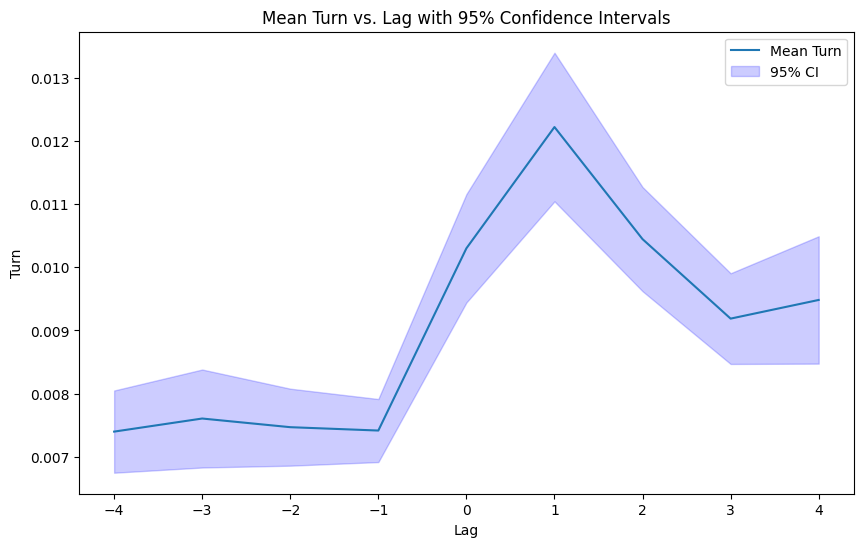

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming 'df' is your DataFrame and it has the columns 'turn' and 'lag'
stock_prices_df['turn'] = stock_prices_df['TR.Volume'] / stock_prices_df['TR.SharesOutstanding']

# Group by 'lag' and calculate the mean and standard error of 'turn'
grouped = stock_prices_df[(stock_prices_df['lag']>-5) & (stock_prices_df['lag']<5)].groupby('lag')['turn'].agg(['mean', 'count', 'std'])
grouped['sem'] = grouped['std'] / np.sqrt(grouped['count'])

# Calculate the 95% confidence intervals
grouped['ci95_hi'] = grouped['mean'] + 1.96 * grouped['sem']
grouped['ci95_lo'] = grouped['mean'] - 1.96 * grouped['sem']

# Check the calculated values
print(grouped.head())

# Plot the mean 'turn' with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(grouped.index, grouped['mean'], label='Mean Turn')
plt.fill_between(grouped.index, grouped['ci95_lo'], grouped['ci95_hi'], color='b', alpha=0.2, label='95% CI')

# Adding labels and title
plt.xlabel('Lag')
plt.ylabel('Turn')
plt.title('Mean Turn vs. Lag with 95% Confidence Intervals')

# Adding a legend
plt.legend()

# Show the plot
plt.show()